# Abdullah Alhussni - aa10108
## Applied Machine Learning - ENGR-UH 3332 - Bonus Project

### Relevant libraries

In [1]:
import numpy as np
from keras.datasets import mnist
from PIL import Image
import matplotlib.pyplot as plt

2024-12-10 06:58:48.356874: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Functions we'll use

In [2]:
def conv3(x, y): # hardcoded for f = 3, p = 0, s = 1, and an input with one channel
    a = np.zeros(shape = (x.shape[0] - 2, x.shape[1] - 2))
    for i in range(a.shape[0]):
        for j in range(a.shape[1]):
            a[i][j] = np.sum(x[i:i + 3, j:j + 3] * y)
    return a

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_deriv(x):
    return sigmoid(x) * (1 - sigmoid(x))

def avg_pool(x):  # hardcoded for f = 2, p = 0, s = 2
    a = np.zeros(shape = (x.shape[0], x.shape[1] // 2, x.shape[2] // 2))
    for c in range(a.shape[0]):
        for i in range(a.shape[1]):
            for j in range(a.shape[2]):
                a[c, i, j] = np.sum(x[c, 2 * i:2 * i + 2, 2 * j:2 * j + 2]) / 4
    return a

def flatten(x):
    return x.reshape(np.prod(x.shape))

def conv1(x, y):
    num_filters = y.shape[-1]
    a = np.zeros((1, 1, num_filters))

    for k in range(num_filters):
        a[0, 0, k] = np.sum(x * y[0, 0, :, k])

    return a

def softmax(x):
    exp_x = np.exp(x - np.max(x))  # prevents overflow
    return exp_x / np.sum(exp_x)

def cross_entropy_loss(predictions, labels):
    return -np.sum(labels * np.log(predictions + 1e-9))  # add epsilon to avoid log(0)

def onehot(y):
    one_hot = np.zeros((y.size, 10))
    one_hot[np.arange(y.size), y] = 1
    return one_hot

### The network structure
#### Per batch/sample:

- Input: 28x28x1
- Output of the 3x3 Convolution: 26x26x2
-- (We're using two channels for the output, and using the formula for output size, we get o = (i + 2 * p - f)  / s + 1 = (28 + 2 * 0 - 3) / 1 + 1 = 26)
- Output of the sigmoid activation is the same: 26x26x2
- Output of the average pooling: 13x13x2
- Output of the flattening: 338 (or 338x1x1)
-- (13 * 13 * 2)
- Output of the 1x1 Convolution: 1x1x10
- Output of the softmax activation is the same: 1x1x10

In [ ]:
class CNN(): # to save computation, I just hard coded the numbers here, but including self.X = X_train would have done the same, I included the formulae
    def __init__(self):
        self.conv3 = np.random.randn(3, 3, 2) / 3 # / 3 = np.sqrt(2 / (3 * 3 * 2)) # better initialization
        self.flat_shape = 338 # 2 * ((self.X.shape[1] - 2) // 2) ** 2
        self.conv1 = np.random.randn(1, 1, 338, 10) / 13 # * np.sqrt(2 / self.flat_shape) # better initialization
        self.bias = np.random.randn(1, 1, 1, 10)
        self.pre_pool_shape = (2, 26, 26)
        self.avg_pool_shape = (2, 13, 13)
        self.input_image = None
        self.post_conv3 = None
        self.pre_pool = None
        self.flattened_input = None

    def first(self, inp):
        return np.array([conv3(inp, self.conv3[:, :, 0]), conv3(inp, self.conv3[:, :, 1])])
        
    def final(self, inp):
        return conv1(inp, self.conv1) + self.bias
    
    def forward(self, x):
        self.input_image = x
        x = self.first(x)   # shape: (2, 26, 26)
        self.post_conv3 = x
        x = sigmoid(x)       # still (2, 26, 26)
        self.pre_pool = x
        x = avg_pool(x)      # shape: (2, 13, 13)
        x = flatten(x)       # shape: (338,)
        self.flattened_input = x
        x = self.final(x)    # shape: (1,1,10), after conv1 and bias add
        x = softmax(x)
        return x.reshape(10,) # return as a flat vector of length 10

    def backward(self, predictions, labels, learning_rate):
        # predictions and labels are now both (10,) vectors
        d_softmax = predictions - labels  # shape: (10,)

        # backprop for conv1 weights
        d_conv1_weights = np.outer(self.flattened_input, d_softmax).reshape(self.conv1.shape)
        self.conv1 -= learning_rate * d_conv1_weights

        # backprop for bias
        d_bias = d_softmax.reshape(self.bias.shape)
        self.bias -= learning_rate * d_bias

        # backprop to flattened layer
        # self.conv1 shape: (1, 1, 338, 10)
        # extract weights as a matrix: (338, 10)
        W = self.conv1[0, 0, :, :]
        d_flatten = np.dot(d_softmax, W.T)  # shape: (338,)

        # reshape to match avg_pool output shape (2, 13, 13)
        d_avg_pool = d_flatten.reshape(self.avg_pool_shape)

        # backprop through avg_pool
        d_pool = np.zeros_like(self.pre_pool)
        for c in range(d_pool.shape[0]):
            for i in range(d_avg_pool.shape[1]):
                for j in range(d_avg_pool.shape[2]):
                    h_start, h_end = i * 2, i * 2 + 2
                    w_start, w_end = j * 2, j * 2 + 2
                    d_pool[c, h_start:h_end, w_start:w_end] += d_avg_pool[c, i, j] / 4

        # check shapes
        if d_pool.shape != self.post_conv3.shape:
            raise ValueError(f"Shape mismatch: d_pool {d_pool.shape} and post_conv3 {self.post_conv3.shape}")

        # backprop through sigmoid
        d_sigmoid = d_pool * sigmoid_deriv(self.post_conv3)

        # backprop through conv3
        d_conv3 = np.zeros(self.conv3.shape) # shape: (3, 3, 2)
        for k in range(self.conv3.shape[-1]):
            for i in range(26 - 2):
                for j in range(26 - 2):
                    d_conv3[:, :, k] += d_sigmoid[k, i, j] * self.input_image[i:i + 3, j:j + 3]

        self.conv3 -= learning_rate * d_conv3

    def train(self, learning_rate, epochs, X_train, y_train, X_test, y_test):
        trainingloss = []
        testloss = []
        for epoch in range(epochs):
            indices = np.arange(len(X_train))
            np.random.shuffle(indices)
            X_train = X_train[indices]
            y_train = y_train[indices]

            avg_train_loss = 0
            # training loop
            for i in range(len(X_train)):
                x_sample = X_train[i]
                y_sample = y_train[i] # this should be a one-hot vector of length 10
                predictions = self.forward(x_sample) # shape: (10,)
                loss = cross_entropy_loss(predictions, y_sample)
                self.backward(predictions, y_sample, learning_rate)
                avg_train_loss += loss
            trainingloss.append(avg_train_loss / len(X_train))

            # testing loop
            avg_test_loss = 0
            for i in range(len(X_test)):
                preds = self.forward(X_test[i])  # (10,)
                # y_test[i] should also be one-hot
                loss = cross_entropy_loss(preds, y_test[i])
                avg_test_loss += loss
            testloss.append(avg_test_loss / len(X_test))

            print(f"Epoch {epoch + 1}: Training Loss = {avg_train_loss / len(X_train)}, Test Loss = {avg_test_loss / len(X_test)}")

        return trainingloss, testloss
    
    def accuracy(self, X_test, y_test):
        count = 0
        for i in range(len(y_test)):
            preds = self.forward(X_test[i])  # preds is now (10,)
            y_pred = np.argmax(preds)
            if y_pred == y_test[i]:
                count += 1
        return count / len(y_test)

    def restart(self):
        self.conv3 = np.random.randn(3, 3, 2) / 3
        self.conv1 = np.random.randn(1, 1, 338, 10) / 13
        self.bias = np.random.randn(1, 1, 1, 10)
        self.input_image = None
        self.post_conv3 = None
        self.pre_pool = None
        self.flattened_input = None

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

Y_train = onehot(y_train)
Y_test = onehot(y_test)

mnistCNN = CNN()
n_epochs = 10
eta = 0.001
trainingloss, testloss = mnistCNN.train(eta, n_epochs, X_train, Y_train, X_test, Y_test)

Epoch 1: Training Loss = 1.04436188375831, Test Loss = 0.571956648282366
Epoch 2: Training Loss = 0.5145370909958373, Test Loss = 0.4466421691774978
Epoch 3: Training Loss = 0.43733606483456317, Test Loss = 0.40126777232658467
Epoch 4: Training Loss = 0.40096199051774, Test Loss = 0.3703085355595393
Epoch 5: Training Loss = 0.3783321816873301, Test Loss = 0.35017211923901526
Epoch 6: Training Loss = 0.3622766651523854, Test Loss = 0.3393788409452844
Epoch 7: Training Loss = 0.34962988487713376, Test Loss = 0.3286840609648948
Epoch 8: Training Loss = 0.3392661147928321, Test Loss = 0.31743303720895466
Epoch 9: Training Loss = 0.330563124661479, Test Loss = 0.30999017229075126
Epoch 10: Training Loss = 0.3228771216085192, Test Loss = 0.3022563654685403


In [5]:
accuracy = mnistCNN.accuracy(X_test, y_test)
print(f"The accuracy on the test data after {n_epochs} epochs is {accuracy:.2%}")
mnistCNN.restart()

The accuracy on the test data after 10 epochs is 91.63%


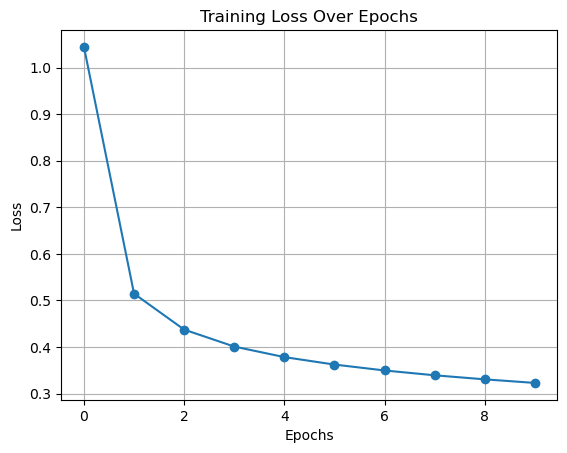

In [6]:
plt.plot(trainingloss, marker = 'o')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

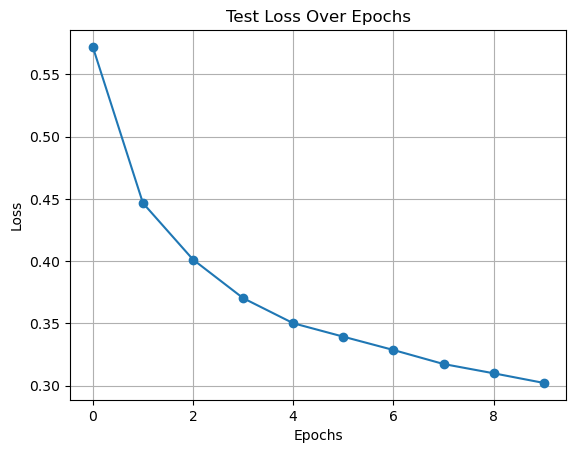

In [7]:
plt.plot(testloss, marker = 'o')
plt.title("Test Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.show()